# Rotated rectangle

In [1]:
import numpy as np
import uproot
import uproot_methods
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplhep as hep
from glob import glob
import re

def my_style(title='', xtitle='', ytitle='', gridstyle=':'):
    plt.grid(linestyle=gridstyle)
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    
%matplotlib inline
import matplotlib
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='paper', ticks=True, grid=True, gridlines='--', figsize=(13, 9), fscale=2)
# jtplot.style(theme='monokai', context='talk', ticks=True, grid=True, gridlines='--', figsize=(13, 9), fscale=2)
# matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']

/home/petrov/.local/lib/python3.7/site-packages/mplhep/__init__.py:48: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)


## Наклон от энергии пучка

In [2]:
def rot_ang_fit(x, a, b, c):
    return b/(x-a) + c#c*np.exp(-a*x)+b
def rot_ang_minmizer(a, b, c):
    return np.sum( np.abs( rot_ang_fit(df.index*2e-3, a, b, c) - df.rot_angle ) )

def s1_fit(x, a, b, c):
    return b*(x-a) + c
def s1_minmizer(a, b, c):
    return np.sum( np.abs( s1_fit(df.index*2e-3, a, b, c) - df.s1 ) )

def fit_text(m):
    text = "Fit results:\n"
    for par, val, err in zip(m.parameters, m.np_values(), m.np_errors() ):
        text += '{} = {:.2f}±{:.2f}\n'.format(par, val, err )
    return text

In [3]:
mom = uproot.pandas.iterate('/spoolA/petrov/research/outputs/model_old_v7/trees/*.root', treepath='pic_mom', 
                            flatten=False, reportpath=True)

In [4]:
mt = pd.concat([m.assign(path=float(re.findall(r'(\d+.\d+)_',p)[0])) for p,m in mom]).query('align>0.8&mass>400&path>520')

In [5]:
mt.head()

,align,momentum,mass,passed,m1,m2,simtypes,gamma_energy,path
0,0.932937,362.251984,522.613403,False,173.958122,-474.906972,"[130.0, 310.0]",734.832397,1000.0
1,0.999996,852.839050,496.942139,True,3.684365,-14.101664,"[130.0, 310.0]",0.000000,1000.0
2,0.999309,432.578613,495.029022,False,126.724182,-415.952008,"[130.0, 310.0]",738.786011,1000.0
3,0.995988,365.947876,516.668884,False,167.183938,-473.144200,"[130.0, 310.0]",740.985535,1000.0
4,0.937374,335.290710,497.361816,False,157.857523,-508.153380,"[130.0, 310.0]",740.440002,1000.0


In [6]:
mom_tree = mt.query('gamma_energy<25')

In [7]:
cov_tree = mom_tree.groupby('path').apply(lambda x: np.cov(x.momentum, x.mass) )

In [8]:
from scipy import linalg as la
eigens = cov_tree.apply(lambda x: la.eig(x))
eigens.head()

path
550.0    ([(302.7205214581388+0j), (76.15328391771253+0...
562.5    ([(342.29154147287625+0j), (67.2252240661425+0...
575.0    ([(390.4970983123303+0j), (63.528809374610375+...
587.5    ([(402.65962971721353+0j), (61.313132465127254...
600.0    ([(471.4440353744585+0j), (57.25992773327057+0...
dtype: object

In [9]:
rot_angle = list( map(lambda x: np.arccos( x[1][0,0] ), eigens) )
s1 = list( map(lambda x: np.sqrt( np.abs( x[0][0] ) ), eigens) )
s2 = list( map(lambda x: np.sqrt( np.abs( x[0][1] ) ), eigens) )
df = pd.DataFrame({'rot_angle':rot_angle, 's1':s1, 's2':s2}, index=eigens.index)
df['m0'] = 497.6
df['p0'] = np.sqrt(df.index**2 - df.m0**2)
df.head()

,rot_angle,s1,s2,m0,p0
path,,,,,
550.0,0.666309,17.398866,8.726585,497.6,234.295198
562.5,0.662347,18.501123,8.199099,497.6,262.298475
575.0,0.636926,19.760999,7.970496,497.6,288.130595
587.5,0.627376,20.066381,7.830270,497.6,312.330738
600.0,0.572710,21.712762,7.567029,497.6,335.252502


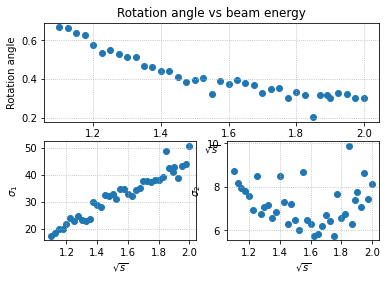

In [10]:
plt.subplot(211)
plt.scatter(df.index*2e-3, df.rot_angle)
my_style('Rotation angle vs beam energy', '$\\sqrt{s}$', 'Rotation angle')
plt.subplot(223)
plt.scatter(df.index*2e-3, df.s1)
my_style('', '$\\sqrt{s}$', '$\\sigma_1$')
plt.subplot(224)
plt.scatter(df.index*2e-3, df.s2)
my_style('', '$\\sqrt{s}$', '$\\sigma_2$')

## Параметризовать зависимости

In [11]:
from iminuit import Minuit

In [12]:
m = Minuit(rot_ang_minmizer, a=0.720, b=0.2, c=0.13, error_a=0.1, error_b=0.01, error_c=0.01, errordef=1)
m.migrad()

------------------------------------------------------------------
| FCN = 0.6136                  |     Ncalls=233 (233 total)     |
| EDM = 7.05E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | a    |   0.732   |   0.010   |            |            |         |         |       |
| 1 | b    |   0.205   |   0.007   |            |            |         |         |       |
| 2 | c    |   0.140   |   0.014   |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [13]:
m_s1 = Minuit(s1_minmizer, a=0.5, b=29.2, c=0.97, error_a=0.1, error_b=0.01, error_c=0.01, errordef=1)
m_s1.migrad()

------------------------------------------------------------------
| FCN = 59.03                   |     Ncalls=117 (117 total)     |
| EDM = 8.56E-08 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | a    |    0.5    |   42.0    |            |            |         |         |       |
| 1 | b    |  29.201   |   0.004   |            |            |         |         |       |
| 2 | c    |   0.955   |   0.002   |            |            |         |         |       |
------------------------------------------------------------------------------------------

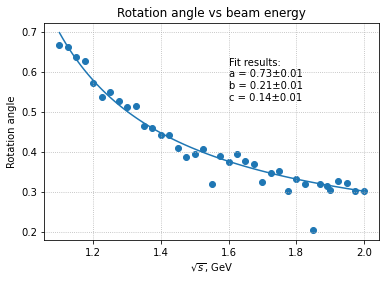

In [15]:
plt.subplot(111)
plt.scatter(df.index*2e-3, df.rot_angle)
my_style('Rotation angle vs beam energy', '$\\sqrt{s}$, GeV', 'Rotation angle')
xx = np.linspace(1.1, 2, 100)
plt.plot(xx, rot_ang_fit(xx, *m.np_values()), label='Fit')
plt.text(1.6, 0.5, fit_text(m))
# plt.savefig('outputs/images/13_rotangle_fit.pdf')#, dpi=150)

## Посмотреть картинки

In [22]:
energy = 600
ang, s1, s2, m0, p0 = \
    rot_ang_fit(energy*2e-3, *m.np_values()), \
    s1_fit(energy*2e-3, *m_s1.np_values()), 2*10, 497.6, np.sqrt(energy**2 - 497.6**2)
s1 = 50

In [23]:
def f0(x):
    return np.array( [m0-(x-p0)/np.tan(ang) - 4*s1/np.sin(ang), m0+(x-p0)*np.tan(ang) - s2/np.cos(ang)] ).max(axis=0)
def f1(x):
    return np.array( [m0-(x-p0)/np.tan(ang) + 4*s1/np.sin(ang), m0+(x-p0)*np.tan(ang) + s2/np.cos(ang)] ).min(axis=0)

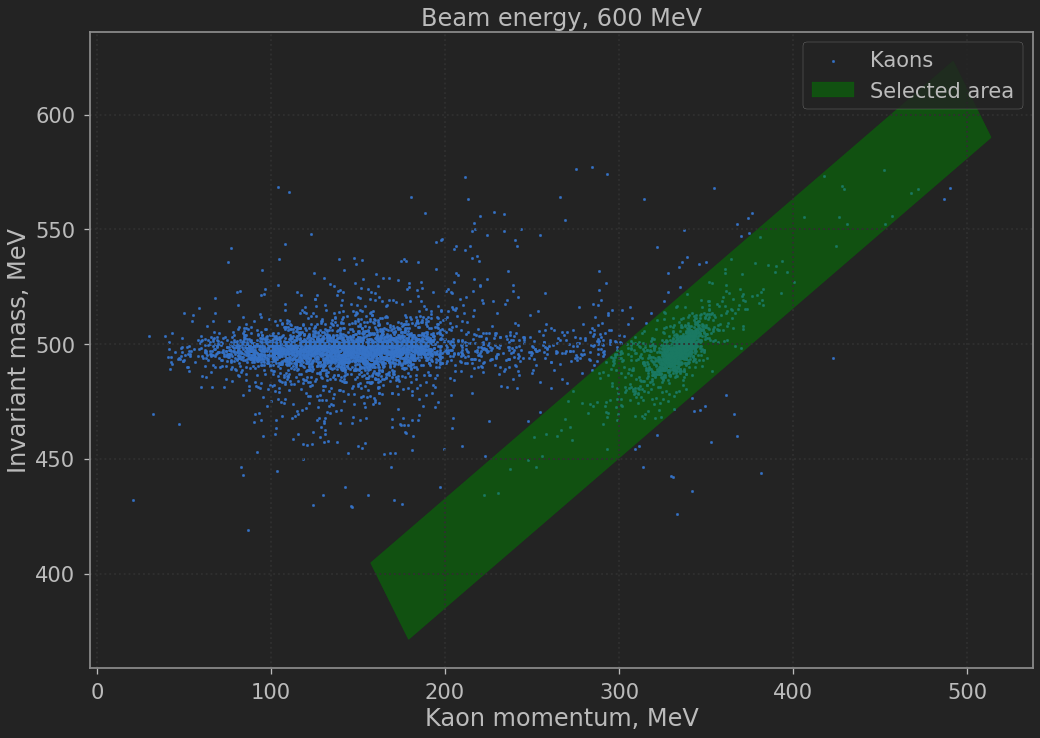

In [24]:
q = f"path=={energy}"
plt.scatter(mt.query(q).momentum, mt.query(q).mass, s=7, label="Kaons")
# plt.scatter(mom_tree.query(q).momentum, mom_tree.query(q).mass, c='yellow', s=7, alpha=0.2, label="Kaons with soft photons")
xx = np.linspace(p0-1000, p0+1000, 5000)
plt.fill_between(xx, f0(xx), f1(xx), where=f0(xx)<f1(xx), color='green', alpha=0.5, label="Selected area")
plt.legend()
my_style(f'Beam energy, {energy} MeV', 'Kaon momentum, MeV', 'Invariant mass, MeV')
# plt.savefig('outputs/images/13_mc_rot550.png', dpi=200)

## Теперь что-то по фону по мультиадронному генератору

In [5]:
def simtypes_to_process(st):
    st = st.copy()
    parts_dict = {111:'$\pi^0$', 211:'$\pi^+$', -211: '$\pi^-$', 321: '$K^+$', -321: '$K^-$', 310:'$K_S$', 130:'$K_L$', \
                  2212:'$p^+$', -2212:'$p^-$', 221:'$\eta$', 2112:'$n^0$', -2112:'$\\bar{n}^0$'}
    num_particles = list(map(lambda x: ''.join(list(map(lambda y: parts_dict[y], x))) , st)) 
    return num_particles

In [6]:
opens = '/spoolA/petrov/research/outputs/others/multihadrons/trees/*.root'
it = uproot.pandas.iterate(opens, treepath='pic_mom', flatten=False, reportpath=True)

In [7]:
sigbkg = pd.concat([m.assign(path=float(re.findall(r'(\d+.\d+)_',p)[0])) for p,m in it])\
            .query('align>0.8&mass>400&passed==True')

In [8]:
sigbkg['process_type'] = simtypes_to_process(sigbkg['simtypes'])
sigbkg['is_kskl'] = (sigbkg['process_type'] == '$K_L$$K_S$')

In [9]:
sigbkg['process_type'].value_counts()

$K_L$$K_S$                                    4666
$\pi^+$$\pi^+$$\pi^-$$\pi^-$                    16
$\pi^+$$\pi^0$$\pi^0$$\pi^-$                     5
$\pi^+$$\pi^-$                                   2
$\pi^+$$\pi^-$$\pi^0$$\pi^0$$\pi^0$$\pi^0$       1
$\pi^0$$K^+$$K^-$                                1
$K^+$$K^-$                                       1
$\pi^+$$\pi^-$$\pi^0$                            1
$\pi^+$$K_S$$K^-$                                1
Name: process_type, dtype: int64

In [10]:
sigbkg2 = sigbkg.groupby('path').agg({'is_kskl':['mean', 'count']})
sigbkg2.columns = ['mean', 'count']
sigbkg2['errs'] = np.sqrt( sigbkg2['mean']*(1-sigbkg2['mean'])/sigbkg2['count'] )

In [69]:
1-sigbkg2['mean'].min()

0.024271844660194164

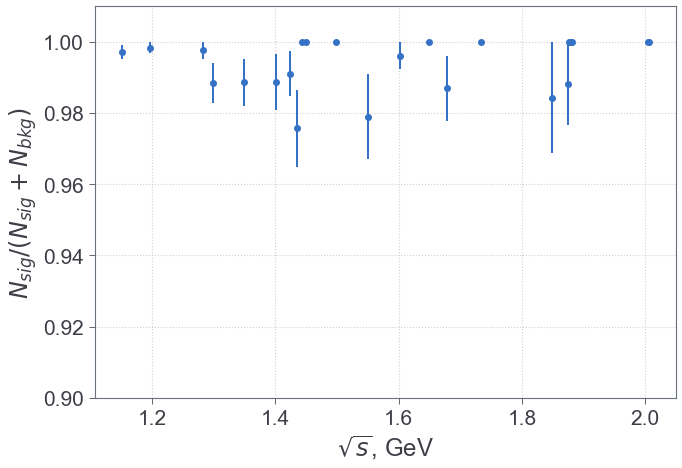

In [71]:
plt.errorbar(sigbkg2.index*2e-3, sigbkg2['mean'], yerr=sigbkg2.errs, fmt='o', ms=7, lw=2)
plt.ylim(0.9, 1.01);
my_style('', '$\\sqrt{s}$, GeV', '$N_{sig}/(N_{sig}+N_{bkg})$')
# plt.savefig('outputs/images/13_sigbkg.pdf')

In [54]:
openfile = '/spoolA/petrov/research/outputs/others/multihadrons/trees/1002.31_45668.root'
df_exp = uproot.open(openfile)['pic_mom'].pandas.df(flatten=False).query('abs(mass-500)<50&align>0.8')
energy = float(re.findall(r'\d+.\d+', openfile)[0])
df_exp['process_type'] = simtypes_to_process(df_exp['simtypes'])

In [55]:
df_exp.head()

,align,momentum,mass,passed,m1,m2,simtypes,gamma_energy,process_type
entry,,,,,,,,,
0,0.999201,430.165375,493.891907,False,126.899196,-421.210570,"[310.0, 130.0, 211.0, -211.0]",10.273181,$K_S$$K_L$$\pi^+$$\pi^-$
3,0.999914,239.881546,490.625000,False,180.209172,-603.903357,"[310.0, 310.0, 211.0, -211.0]",32.781376,$K_S$$K_S$$\pi^+$$\pi^-$
4,0.978291,392.684814,513.216858,False,156.469927,-451.274136,"[321.0, 310.0, -211.0, 111.0]",14.774487,$K^+$$K_S$$\pi^-$$\pi^0$
5,0.985519,233.488129,491.715607,False,183.146728,-609.685742,"[310.0, 130.0, 211.0, -211.0]",0.000000,$K_S$$K_L$$\pi^+$$\pi^-$
6,0.998847,463.761719,502.288269,False,124.954634,-386.635551,"[321.0, 310.0, -211.0, 111.0]",108.278122,$K^+$$K_S$$\pi^-$$\pi^0$


In [56]:
df_exp.groupby('process_type').agg({'passed':'count'}).sort_values(by='passed', ascending=False).head()

,passed
process_type,
$K^+$$K_S$$\pi^-$$\pi^0$,2321
$K_L$$K_S$$\pi^0$$\pi^0$,1218
$K_S$$K_L$$\pi^+$$\pi^-$,772
$\pi^+$$K_S$$K^-$,319
$\pi^-$$K_S$$K^+$,310


In [57]:
df_exp.query('passed==True').groupby('process_type').agg({'passed':'count'}).sort_values(by='passed', ascending=False)

,passed
process_type,
$K_L$$K_S$,18


In [58]:
df_exp['is_kskl'] = (df_exp['process_type'] == '$K_L$$K_S$')

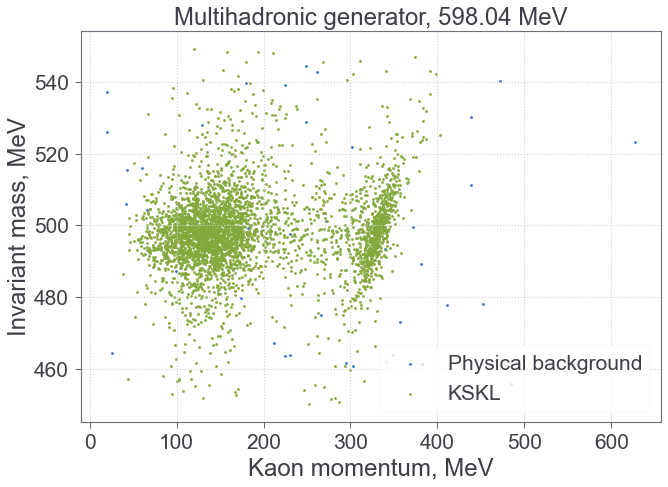

In [31]:
df_non = df_exp.query('is_kskl==False')
df_k = df_exp.query('is_kskl==True')

plt.scatter(df_non.momentum, df_non.mass, s=7, label='Physical background')
plt.scatter(df_k.momentum, df_k.mass, s=7, label='KSKL')
ang, s1, s2, m0, p0 = \
    rot_ang_fit(energy*2e-3, 0.732, 0.205, 0.140), \
    s1_fit(energy*2e-3, 0.5, 29.201, 0.955), 2*10, 497.6, np.sqrt(energy**2 - 497.6**2)
xx = np.linspace(p0-100, p0+100, 500)
# plt.fill_between(xx, f0(xx), f1(xx), where=f0(xx)<f1(xx), color='green', alpha=0.5, label="Selected area")
plt.legend()
my_style(f'Multihadronic generator, {energy} MeV', 'Kaon momentum, MeV', 'Invariant mass, MeV')
# plt.savefig('outputs/images/13_multi825.png', dpi=200)

## Реальные данные

In [24]:
%ls /spoolA/petrov/research/outputs/model_old_v7/trees/

1000.00_0.root  625.00_0.root  725.00_0.root  825.00_0.root  912.50_0.root
508.60_1.root   637.50_0.root  737.50_0.root  837.50_0.root  925.00_0.root
550.00_0.root   650.00_0.root  750.00_0.root  83??k?         935.00_0.root
562.50_0.root   662.50_0.root  762.50_0.root  850.00_0.root  945.00_0.root
575.00_0.root   675.00_0.root  775.00_0.root  862.50_0.root  950.00_0.root
587.50_0.root   687.50_0.root  787.50_0.root  875.00_0.root  962.50_0.root
600.00_0.root   700.00_0.root  800.00_0.root  887.50_0.root  975.00_0.root
612.50_0.root   712.50_0.root  812.50_0.root  900.00_0.root  987.50_0.root


In [38]:
mc_file = '/spoolA/petrov/research/outputs/model_old_v7/trees/800.00_0.root'
df_mc = uproot.open(mc_file)['pic_mom'].pandas.df(flatten=False).query('align>0.8')

In [39]:
file = '/spoolA/petrov/research/outputs/19/trees/800.00_76450.root'
energy = float(re.findall(r'\d+.\d+', file)[0])
df_exp = uproot.open(file)['pic_mom'].pandas.df(flatten=False)

In [40]:
df_exp['alpha'] = np.arccos(df_exp['align'])
a0 = np.arccos(0.8)
df_al_good = df_exp.query('alpha<@a0')
df_al_bad = df_exp.query('alpha>@a0&alpha<2*@a0')

In [41]:
ang, s1, s2, m0, p0 = \
    rot_ang_fit(energy*2e-3, 0.732, 0.205, 0.140), \
    s1_fit(energy*2e-3, 0.5, 29.2, 0.955), 10, 497.6, np.sqrt(energy**2 - 497.6**2)

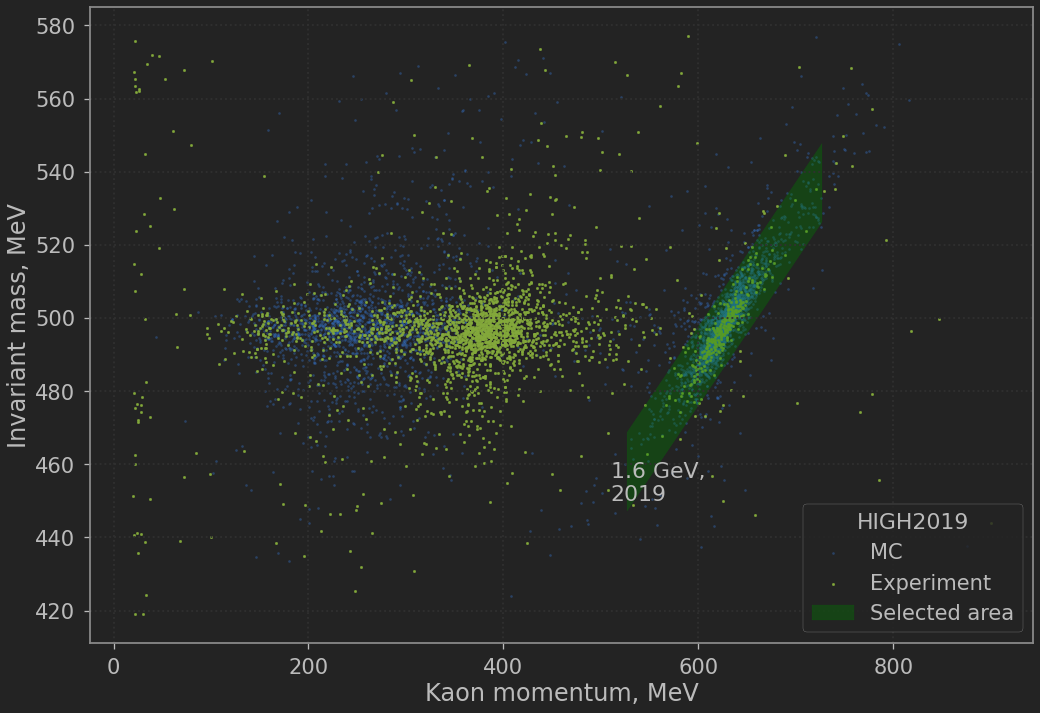

In [42]:
plt.scatter(df_mc.momentum, df_mc.mass, s=5, label='MC', alpha=0.4)
plt.scatter(df_al_good.momentum, df_al_good.mass, s=7, label='Experiment')
# plt.scatter(df_al_bad.momentum, df_al_bad.mass, s=7, label='Side-band')
xx = np.linspace(p0-100, p0+100, 500)
plt.fill_between(xx, f0(xx), f1(xx), where=f0(xx)<f1(xx), color='green', alpha=0.35, label="Selected area")
plt.legend(title='HIGH2019')
plt.text(510, 450, "1.6 GeV,\n2019")
# my_style(f'Experimental data, {energy} MeV', 'Kaon momentum, MeV', 'Invariant mass, MeV')
my_style('', 'Kaon momentum, MeV', 'Invariant mass, MeV')
# plt.savefig('outputs/images/13_real800.png', dpi=200)

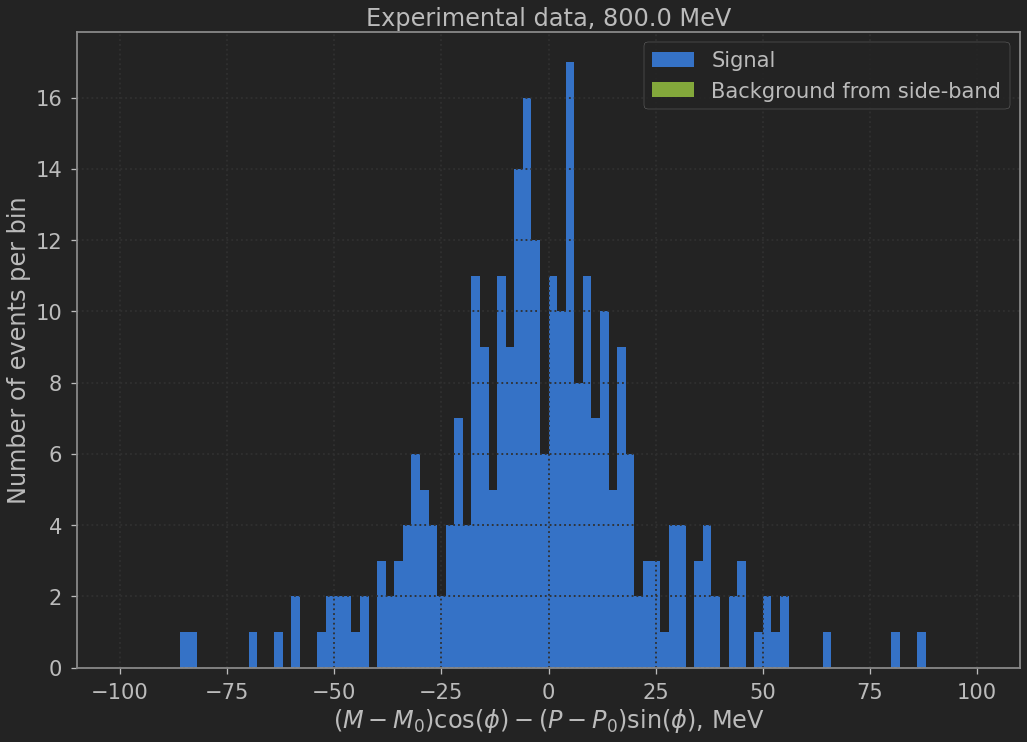

In [43]:
plt.hist( df_al_good.query('abs(m1)<10').m2, bins=100, range=(-100, 100), label='Signal' );
plt.hist( df_al_bad.query('abs(m1)<10').m2, bins=100, range=(-100, 100), label='Background from side-band' );
my_style(f'Experimental data, {energy} MeV', '$(M - M_0) \cos(\phi) - (P - P_0) \sin(\phi)$, MeV', 'Number of events per bin')
# plt.yscale('log')
plt.legend()
# plt.savefig('outputs/images/13_real987_1d.png', dpi=200)

In [19]:
df_al_bad.query('abs(m1)<10')

,align,momentum,mass,passed,m1,m2
entry,,,,,,
92,-0.299657,417.718170,503.312836,True,-4.937430,20.166365
157,-0.610508,359.018646,473.126373,True,-2.088227,-45.778602
216,0.217443,451.040161,520.699707,False,-6.336870,57.725651
290,-0.779403,380.204163,486.126801,True,-1.287269,-20.935178
370,-0.912289,383.636566,494.340240,True,4.147967,-13.885342
409,0.043433,316.351898,441.691284,False,-8.264559,-98.413848
664,-0.435260,340.100616,469.084717,False,3.770511,-64.215034
705,0.748754,433.701874,526.286316,True,7.103802,45.430337
711,-0.091134,267.045685,428.526184,False,4.719228,-147.768116


## Число событий

In [72]:
mom2 = uproot.pandas.iterate('/spoolA/petrov/research/outputs/model_old_v7/trees/*.root', treepath='pic_mom', 
                            flatten=False, reportpath=True)
mt = pd.concat([m.assign(path=float(re.findall(r'(\d+.\d+)_',p)[0])) for p,m in mom2]).query('path>520')\
       [['align', 'm1', 'm2', 'passed', 'path']]

In [74]:
mt.head()

,align,m1,m2,passed,path
0,0.932937,173.958122,-474.906972,False,1000.0
1,0.999996,3.684365,-14.101664,True,1000.0
2,0.999309,126.724182,-415.952008,False,1000.0
3,0.995988,167.183938,-473.144200,False,1000.0
4,0.937374,157.857523,-508.153380,False,1000.0


332


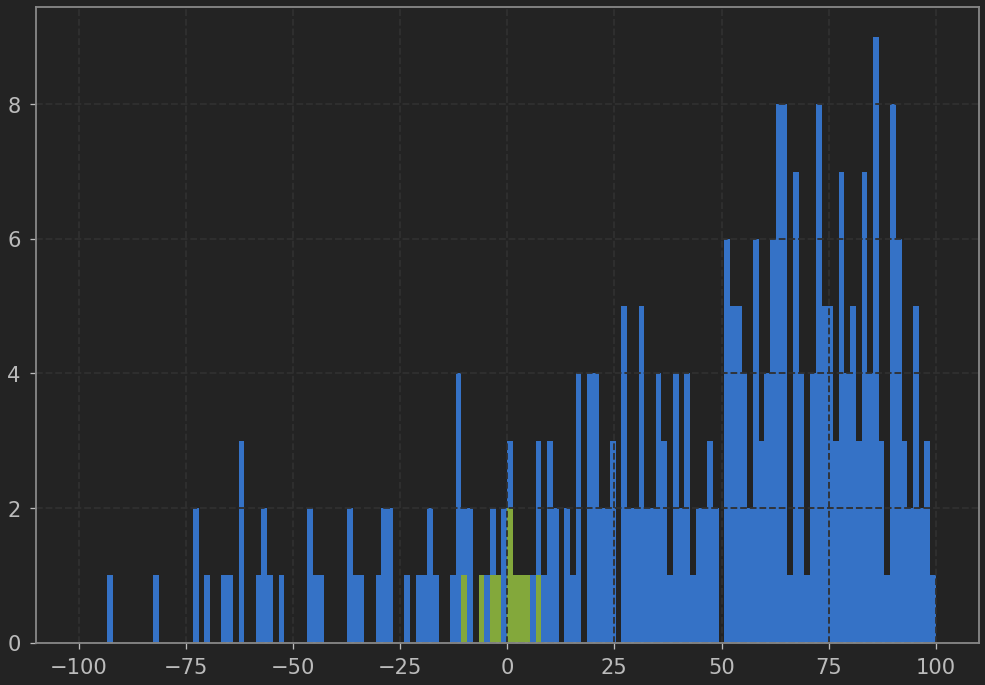

In [90]:
dicx = mt.query('path==550&align<0.8')
print(len(dicx))
plt.hist( dicx['m1'], bins=150, range=(-100, 100) );
plt.hist( dicx.query('passed==True')['m1'], bins=150, range=(-100, 100) );

## Число событий в MC

In [5]:
mom = uproot.pandas.iterate('/spoolA/petrov/research/outputs/model_old_v7/trees/*.root', treepath='pic_mom', 
                            flatten=False, reportpath=True)
mt = pd.concat([m.assign(path=float(re.findall(r'(\d+.\d+)_',p)[0])) for p,m in mom]).query('passed==True&mass>400&path>520')

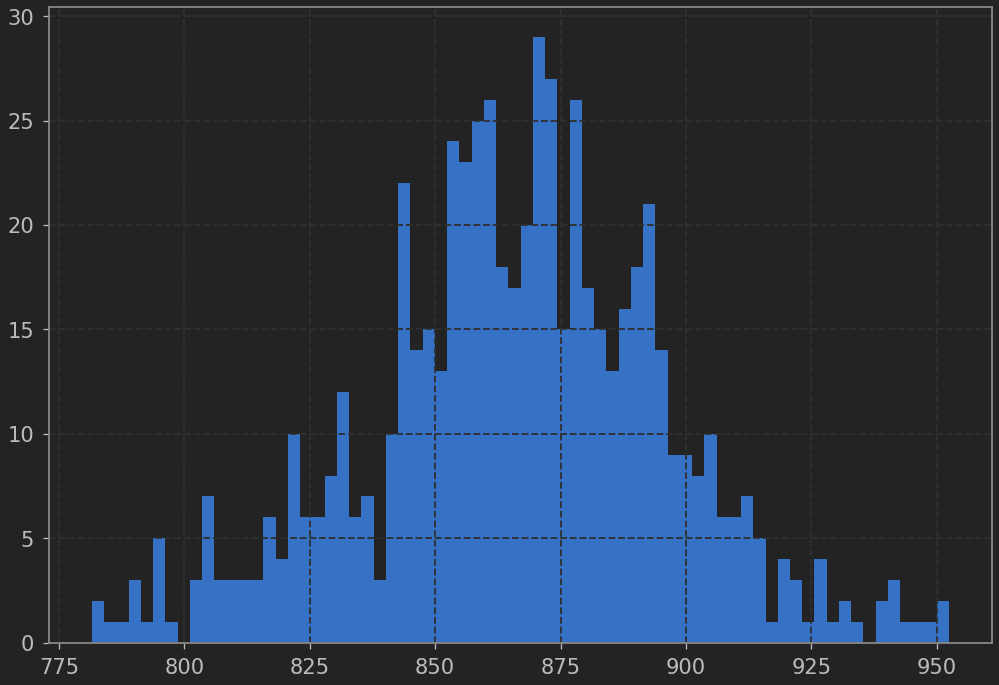

In [12]:
plt.hist( mt[mt.path==1000.].momentum, bins=70);